In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
import xgboost as xgb

import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin1')

In [3]:
df = df[['_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'gender', 'profile_yn', 'created',
       'fav_number', 'link_color', 'name', 'retweet_count', 'sidebar_color', 'tweet_count']].copy()

In [4]:
df['_last_judgment_at'] = pd.to_datetime(df['_last_judgment_at'])
df['created'] = pd.to_datetime(df['created'])

In [5]:
df['target'] = df['gender'].map(lambda x: 1 if x == 'male' else 0)

In [6]:
df = df[(df['gender'] == 'male') | (df['gender'] == 'female')]

In [7]:
df['gender'] = df['gender'].astype(str)

In [8]:
df.drop('gender', axis=1, inplace=True)

In [9]:
df['_golden'] = df['_golden'].map(lambda x: 1 if x == 'True' else 0)

In [11]:
df['_unit_state'] = df['_unit_state'].map(lambda x: 1 if x == 'finalized' else 0)

In [13]:
df['_last_judgment_at'] = df['_last_judgment_at'].fillna(df['_last_judgment_at'].mean())

In [14]:
df['judge_hour'] = df['_last_judgment_at'].dt.hour

In [16]:
df.drop('_last_judgment_at', axis=1, inplace=True)

In [23]:
df['profile_yn'] = df['profile_yn'].map(lambda x: 1 if x == 'yes' else 0)

In [26]:
df['created_hr'] = df['created'].dt.hour

In [27]:
df.drop('created', axis=1, inplace=True)

In [28]:
df.sample(5)

,_golden,_unit_state,_trusted_judgments,profile_yn,fav_number,link_color,name,retweet_count,sidebar_color,tweet_count,target,judge_hour,created_hr
18126,0,1,3,1,1846,0084B4,ainsleighg01,0,C0DEED,3201,0,22,14
13342,0,1,3,1,210,EB15E4,WamShitcomb,0,EEEEEE,19955,0,0,22
19099,0,1,3,1,343,990000,SoFire,0,0,82852,0,0,8
2389,0,1,3,1,739,0084B4,tayloralyssum,0,C0DEED,3916,0,23,17
1107,0,1,3,1,14,89C9FA,OstapKohlstein,0,0,1373,1,22,4


In [29]:
df.drop('name', axis=1, inplace=True)

In [30]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=25)

In [31]:
enc = TargetEncoder()
data_train = enc.fit_transform(X_train, y_train)
data_test = enc.transform(X_test)

# Random Forest Classifier

In [34]:
rfc = RandomForestClassifier()
rfc.fit(data_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
y_pred_rfc = rfc.predict(data_test)

In [37]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.62      0.65      0.64      1683
           1       0.60      0.57      0.58      1541

    accuracy                           0.61      3224
   macro avg       0.61      0.61      0.61      3224
weighted avg       0.61      0.61      0.61      3224



In [38]:
ns = 1 - y_test.mean()
print(f'Null score: {ns}')

Null score: 0.5220223325062034


Random Forest Classifier: f1=0.581 auc=0.622


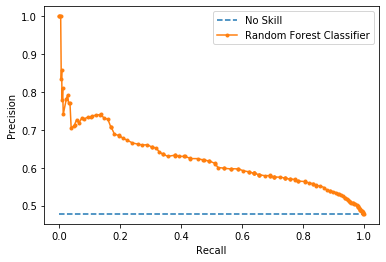

In [41]:
rfc_probs = rfc.predict_proba(data_test)
# keep probabilities for the positive outcome only
rfc_probs= rfc_probs[:, 1]
# predict class values
yhat = rfc.predict(data_test)
rfc_precision, rfc_recall, _ = precision_recall_curve(y_test, rfc_probs)
rfc_f1, rfc_auc = f1_score(y_test, y_pred_rfc), auc(rfc_recall, rfc_precision)
# summarize scores
print('Random Forest Classifier: f1=%.3f auc=%.3f' % (rfc_f1, rfc_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rfc_recall, rfc_precision, marker='.', label='Random Forest Classifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

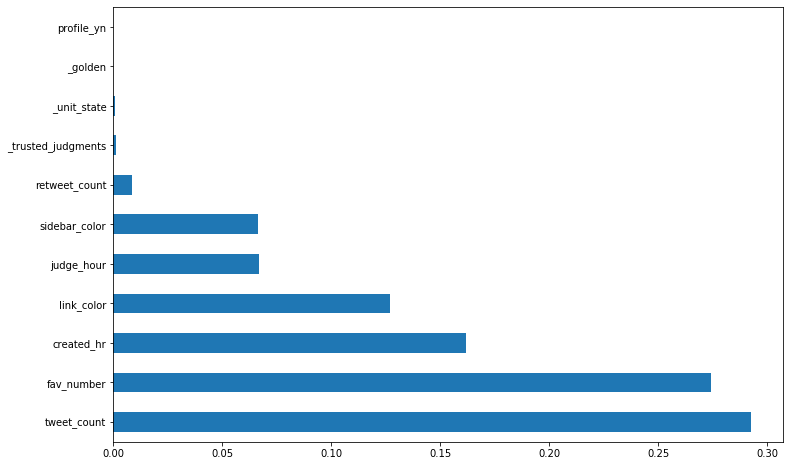

In [45]:
# Feature importance
feat_importances = pd.Series(rfc.feature_importances_, index=data_train.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(12, 8))
plt.show()

# XGBoost

In [47]:
xgb = xgb.XGBClassifier()
xgb.fit(data_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
y_pred_xgb = xgb.predict(data_test)

In [49]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1683
           1       0.60      0.62      0.61      1541

    accuracy                           0.62      3224
   macro avg       0.62      0.62      0.62      3224
weighted avg       0.62      0.62      0.62      3224

